# LGBM classification of VGG embeddings

In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 0

env: CUDA_VISIBLE_DEVICES=0


Imports

In [13]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import lightgbm as lgb

from batchflow import Pipeline, B, plot
from batchflow.models.torch import TorchModel
from sklearn.decomposition import PCA
from nbtools.core import get_notebook_name

from batchflow.models.metrics import ClassificationMetrics

from loader import ImagesDataset
from evaluator import MetricsEvaluator

Experiment name.

In [3]:
NAME = get_notebook_name()
NAME

'05_LGBM'

Seed fixed.

In [4]:
SEED = 11
rng = np.random.default_rng(SEED)

Load and preprocess data.

In [5]:
DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=SEED)

100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.33s/it]


Load trained model

In [6]:
%%time

MODEL_PATH = '../models/02_VGG.torch'
model = TorchModel()
model.load(MODEL_PATH)
penultimate_module = model.model[1][-2]

CPU times: user 1.29 s, sys: 682 ms, total: 1.97 s
Wall time: 1.98 s


## 

Define and run pipeline that get us penultimate layer activations. Get them for train data.

In [7]:
%%time

predict_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)

    # initialize prediction and metrics containers
    .init_variables('images', 'labels', 'proba', 'predictions', 'metrics')
    
    # import trained model
    .import_model('model', model)
    
    # make predictions
    .predict_model(name='model', inputs=B('images'),
                   outputs=['predictions', 'predicted_proba'], save_to=[B('predictions'), B('proba')])
    
    # get penultimate layer activations
    .call(model.get_intermediate_activations, inputs=B('images'),
          layers=penultimate_module, save_to=B('activations'))
)

predict_pipeline_train = predict_template << dataset.train
train_batch = predict_pipeline_train.next_batch(dataset.train.size)

CPU times: user 781 ms, sys: 1.04 s, total: 1.82 s
Wall time: 8.49 s


Reduce train data activations to 100 features, make a train lgbm-specific dataset.

In [8]:
%%time

n_features = 100
pca = PCA(n_components=n_features, random_state=SEED)
train_features = train_batch.activations.reshape(dataset.train.size, -1)
train_features_reduced = pca.fit_transform(train_features)
train_data = lgb.Dataset(data=train_features_reduced, label=train_batch.labels)

CPU times: user 3min 48s, sys: 3min 59s, total: 7min 48s
Wall time: 11 s


Reduce test data activations to the same 100 features, make a test lgbm-specific dataset.

In [9]:
%%time

predict_pipeline_test = predict_template << dataset.test
test_batch = predict_pipeline_test.next_batch(dataset.test.size)
test_features = test_batch.activations.reshape(dataset.test.size, -1)
test_features_reduced = pca.transform(test_features)
test_data = lgb.Dataset(data=test_features_reduced, label=test_batch.labels)

CPU times: user 6.81 s, sys: 2.11 s, total: 8.92 s
Wall time: 2.59 s


Set training parameters, chosen during iterative research.

In [10]:
train_config = {
    'num_leaves': 16,
    'max_depth': 5,
    'min_data_in_leaf': 20,
    'objective': 'multiclass',
    'num_class': n_classes,
    'verbose': -1,
}

num_round = 50

model = lgb.train(
    params=train_config,
    train_set=train_data,
    num_boost_round=num_round,
    valid_sets=[test_data],
    verbose_eval=False
)

Make predictions via trained booster.

In [11]:
test_targets = test_batch.labels
test_predictions_proba = model.predict(test_features_reduced)
test_predictions = test_predictions_proba.argmax(axis=1)

Evaluate metrics, save them.

,precision,recall
ArtDeco,40.0,50.0
Cubism,71.2,79.2
Impressionism,54.5,65.2
Japonism,63.6,50.0
Naturalism,80.0,71.1
Rococo,65.0,68.4
cartoon,77.8,36.8
photo,71.9,79.3


,accuracy,f1_score
altogether,66.5,64.0


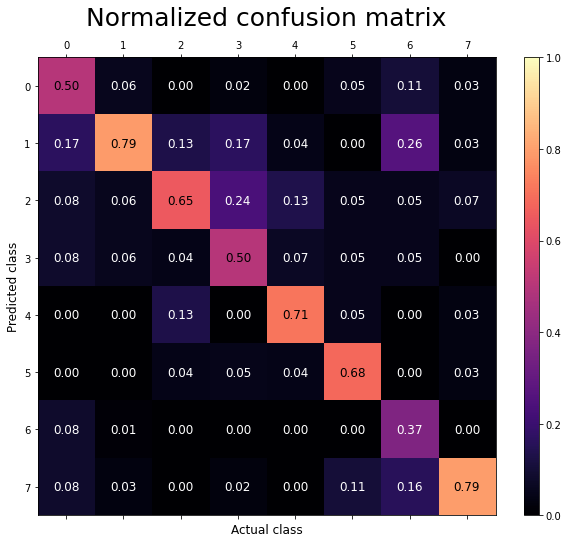

In [16]:
METRICS_PATH = f'../metrics/{NAME}.json'

evaluator = MetricsEvaluator(targets=test_targets, predictions=test_predictions, classes=dataset.classes)
classification_metrics = evaluator.evaluate_classification_metrics(show=True, savepath=METRICS_PATH)